# Disturbances

Looking at SMAD Table 10-18, 3rd Ed.

## Aerodynamic Torques

$$
T_{aero} = \frac {1}{2} \rho V^2 C_d A (u_v \times s_{cp})
$$

- $\rho$: atmospheric density
- $C_d$: drag coefficient (typically 2.25)
- $A$: cross sectional area perpendicular to $u_v$
- $u_v$: unit vector pointing in velocity direction
- $s_{cp}$: vector distance from center of mass to center of pressure

Atmospheric density[ref](https://www.spaceacademy.net.au/watch/debris/atmosmod.htm)

$$
\begin{align}
\rho &= 6 \times 10^{-10} e^{(175-h)/H} \\
H &=T/\mu \\
\mu &= 27-0.012(h-200)\\
T &= 900+2.5(F_{10}-70) + 1.5 A_p
\end{align}
$$

- T: temperature in Kelvin
- h: altitude, 180 < h < 500 km
- H: km
- $\rho$: air density, $kg/m^3$
- $F_{10}$: ranges from 70 (solar EUV) to 300 (soft X-ray)

![](./pics/rho.gif)

## Gravity Gradient Torque

$$
T_{gravGrad} = \frac {3 \mu} {R^3} u_e \times (J \cdot u_e)
$$

- $R$: distance to center of the Earth
- $u_e$: unit vector towards nadir
- $J$: satellite inertia matrix
- $\mu$: Earth's gravitational coefficient 3.986E18 $m^3/s^2$

In [1]:
# reload library
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp as rk45
from squaternion import Quaternion
from helper import plotStates, plotControl

In [3]:
class Satellite:
    """
    This is a simple stupid satellite model. The assumption is, the commanded 
    torques are feed into the model. The torques could come from some external
    forces like thrusters.
    """
    J = np.diag([10,10,10])
    Tlim = 0.9 # Nm
    Hlim = 1.5 # Nms
    dz = 0.05  # Nm
    
    def dynamics(self, t, state, u):
        # state = [q(r,x,y,z), w]
        # u = torques(3)

        J = self.J
        q = Quaternion(*state[:4])
        w = state[4:]
        qw = Quaternion(0, *w)

        ret = np.zeros(7)
        ret[:4] = 0.5*q*qw
        ret[4:] = np.linalg.inv(J) @ (u - np.cross(w, J @ w))
        return ret

def gravGradientTorque(I,q,R):
    """
    SMAD Table 10-18
    """
    mu = 3.986004418E5 # km^3/sec^2
    T = 3 * mu / R**3

In [5]:
qd = Quaternion.from_euler(40,30,-40,degrees=True)

qe = qd.conjugate * Quaternion()
print(f"Error quaternion: {qe:.4f}")
print(f"  Rotation axis: {qe.axis}")
print(f"  Rotation angle: {qe.angle*180/np.pi:.4f} deg")

Error quaternion: Quaternion(w=0.8227, x=-0.3936, y=-0.1156, z=0.3936)
  Rotation axis: (-0.6923482794452575, -0.2032430070097958, 0.6923482794452575)
  Rotation angle: 69.2965 deg


In [7]:
ti = []
yi = []
ui = []
err = []
errdot = []

sat = Satellite()

step = 0.01
t = 0

# [q, w]
y = np.zeros(7)
y[:4] = Quaternion() # set starting quaternion

for i in range(2000):
    u = np.zeros(3)
    q = Quaternion(*y[:4])
    qe = qd.conjugate * q
    axis = np.array(qe.vector)
    u = -10 * axis - 10*y[4:]
    
    # I am using this as an external torque, not wheels
    # u = sat.torqueLimit(u, deadzone=0.0)
    
    y = rk45(sat.dynamics, [t, t+step], y, args=(u,))
    
    if y.success == False:
        print("Oops")
        
    y = y.y[:,-1]
    yi.append(y)
    t += step
    ti.append(t)
    ui.append(u)
    err.append(qe)
    errdot.append(y[4:])
    
yi = np.array(yi)
ti = np.array(ti)
ui = np.array(ui)
err = np.array(err)
errdot = np.array(errdot)

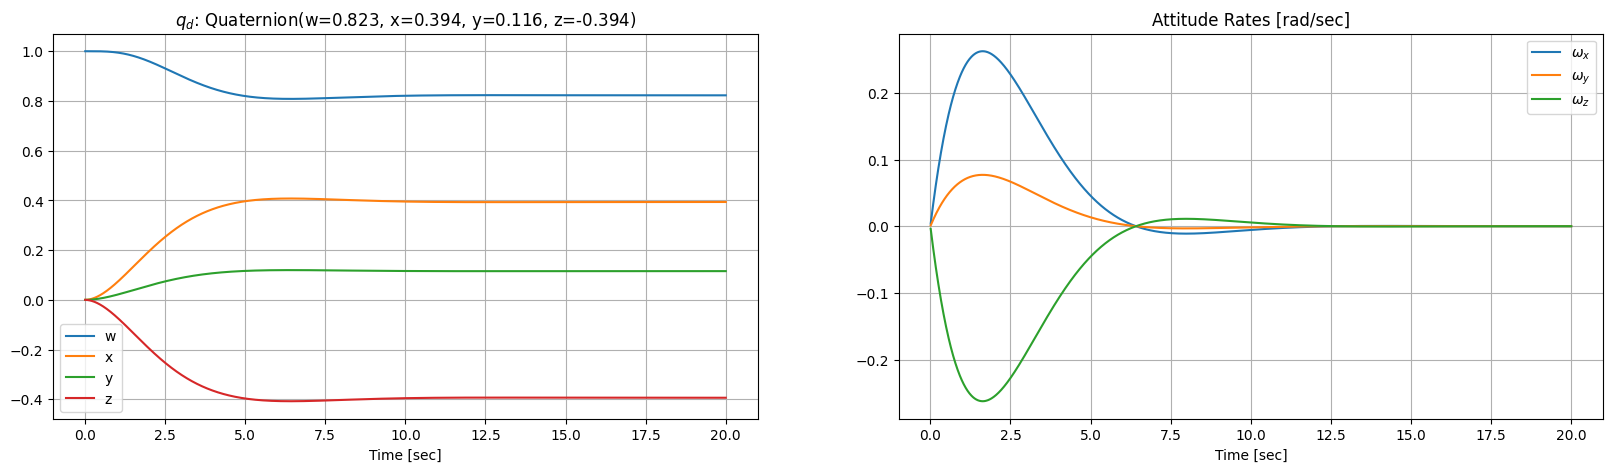

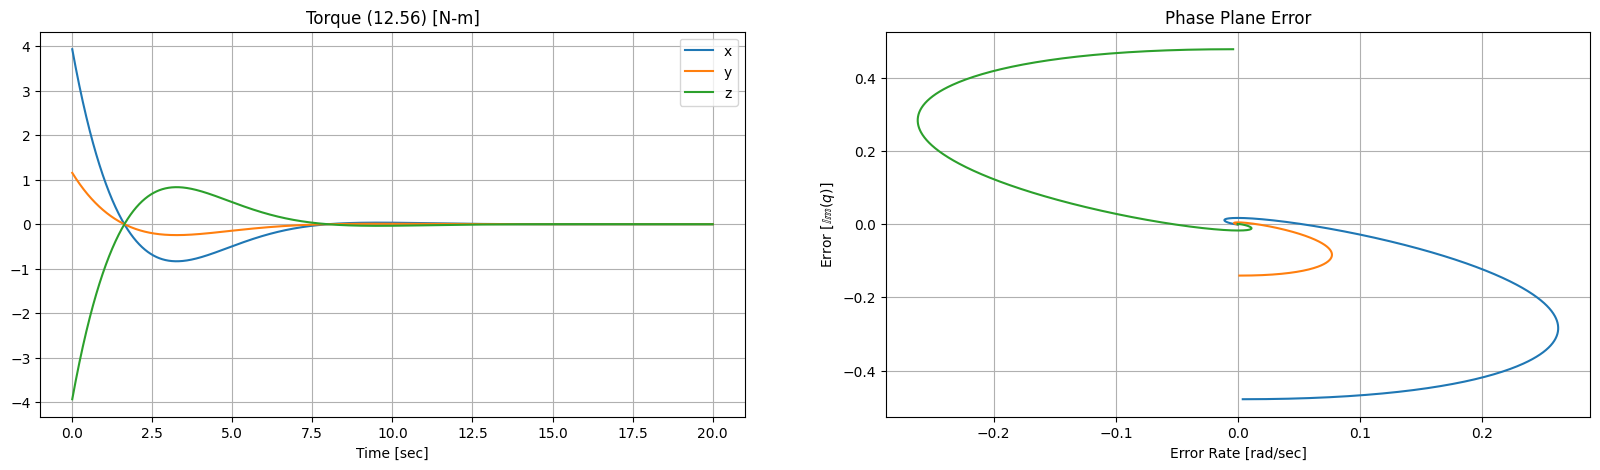

In [8]:
plotStates(ti,yi,qd)
plotControl(ti,ui,err,errdot,step)